In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, Conv2D
from keras.optimizers import SGD, RMSprop
from keras.utils import np_utils, generic_utils
from keras.callbacks import TensorBoard
from keras import backend as K


import tensorflow as tf
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pyplot as pyplot

import numpy as np
import scipy.io
from PIL import Image
from sklearn.cross_validation import train_test_split
from sklearn import cross_validation
from sklearn import preprocessing
from IPython import display
import time

img_rows, img_cols, img_depth = 64, 64, 64

Using TensorFlow backend.
C:\Users\caixiaod\AppData\Local\Continuum\anaconda3\envs\tensorflow\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
root_dir = 'dataset/'
listing = os.listdir(root_dir)
maxval = 0.46
classes = {'none':0, 'left':1, 'right':2, 'click':3, 'wrist':4}
gs_class = {'left', 'right', 'click', 'wrist'}

In [4]:
sess = tf.InteractiveSession()
X = []
y = []

width = 128 # input image shape = [width, width, 3]
delta = 24 # 24*0.625cm = 15cm
esp = 1e-6

for file in listing:
    file = root_dir + file
    data = scipy.io.loadmat(file)
    print(file)
    # set ground truth
    gt = 'none'
    for i in gs_class:
        idx = file.find(i)
        if idx != -1:
            gt = i
            break;
        
        
    raw = data['raw']
    label = data['label']
    speed = data['speed']
    phase = data['phase']
    mask = data['mask']
    
    label_mask = (label != 0)
    label_sum = np.sum(label_mask) # total frames of labels
    
    if label_sum < 30:
        continue
    
    gs_mask = mask[label_mask[:,0], :]
    gs_window = np.sum(gs_mask, 0) / label_sum
    maxval = np.max(gs_window[width:])
    maxidx = np.argmax(gs_window[width:])
    
    if maxval < 0.3:
        continue
        
    gesture_index, b = np.nonzero(label)
    
    # set gesture region, [r_min:r_max, c_min:c_max]
    r_min, r_max = gesture_index[0], gesture_index[-1]
    r_min = max(r_min - delta, 0)
    r_max = max(r_min + width + delta, r_max)
    r_max = min(r_max, len(label))

    body_pos = maxidx + width
    c_min = body_pos - width
    c_max = min(body_pos + delta, raw.shape[1])
    
    if (r_max - r_min < width) or (c_max - c_min < width):
        print(str(c_max-c_min) + ',' + str(r_max-r_min))
        continue
    
    raw_rdm = raw[r_min:r_max, c_min:c_max]
    maxval = np.max(np.abs(raw_rdm)) + esp
    raw_rdm = raw_rdm / maxval
    
    speed_rdm = speed[r_min:r_max, c_min:c_max]
    maxval = np.max(np.abs(speed_rdm)) + esp
    speed_rdm = speed_rdm / maxval
    
    phase_rdm = phase[r_min:r_max, c_min:c_max]
    maxval = np.max(np.abs(phase_rdm)) + esp
    phase_rdm = phase_rdm / maxval
    
    raw_input = np.zeros((r_max-r_min, c_max-c_min, 3))
    raw_input[:,:,0] = raw_rdm
    raw_input[:,:,1] = speed_rdm
    raw_input[:,:,2] = phase_rdm
    
    # data augmentation
    tmp = tf.random_crop(raw_input, [width, width, 3])
    if gt == 'none':
        num_crop = 10
    elif gt == 'left':
        num_crop = 20
    elif gt == 'right':
        num_crop = 20
    elif gt == 'click':
        num_crop = 60
    elif gt == 'wrist':
        num_crop = 60
    else:
        num_crop = 0
    for itr in range(num_crop):
        X.append(sess.run(tmp))
        y.append(classes[gt])
    
    # generate negtive samples
    gt = 'none'
    r_min = int((gesture_index[0] + gesture_index[-1]) / 2)
    r_max = len(label)

    body_pos = maxidx + width
    c_min = body_pos - width
    c_max = min(body_pos + delta, raw.shape[1])
    
    if (r_max - r_min < width) or (c_max - c_min < width):
        print(str(c_max-c_min) + ',' + str(r_max-r_min))
        continue
    
    raw_rdm = raw[r_min:r_max, c_min:c_max]
    maxval = np.max(np.abs(raw_rdm)) + esp
    raw_rdm = raw_rdm / maxval
    
    speed_rdm = speed[r_min:r_max, c_min:c_max]
    maxval = np.max(np.abs(speed_rdm)) + esp
    speed_rdm = speed_rdm / maxval
    
    phase_rdm = phase[r_min:r_max, c_min:c_max]
    maxval = np.max(np.abs(phase_rdm)) + esp
    phase_rdm = phase_rdm / maxval
    
    raw_input = np.zeros((r_max-r_min, c_max-c_min, 3))
    raw_input[:,:,0] = raw_rdm
    raw_input[:,:,1] = speed_rdm
    raw_input[:,:,2] = phase_rdm
    
    # data augmentation
    tmp = tf.random_crop(raw_input, [width, width, 3])
    if gt == 'none':
        num_crop = 10

    for itr in range(num_crop):
        X.append(sess.run(tmp))
        y.append(classes[gt])
sess.close()

C:\Users\caixiaod\AppData\Roaming\Python\Python35\site-packages\tensorflow\python\client\session.py:1711: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


dataset/radar60GHz_click_20180307_100541_963.mat
dataset/radar60GHz_click_20180316_155732_588.mat
dataset/radar60GHz_click_20180326_153916_568.mat
dataset/radar60GHz_click_20180326_153926_166.mat
dataset/radar60GHz_click_20180328_154450_917.mat
dataset/radar60GHz_click_20180328_154511_773.mat
dataset/radar60GHz_click_20180328_154527_808.mat
dataset/radar60GHz_click_20180328_154538_429.mat
dataset/radar60GHz_click_20180328_155855_302.mat
dataset/radar60GHz_click_20180328_155904_979.mat
dataset/radar60GHz_click_20180328_155914_988.mat
dataset/radar60GHz_click_20180328_155928_434.mat
dataset/radar60GHz_click_20180328_161249_822.mat
dataset/radar60GHz_click_20180328_161300_406.mat
dataset/radar60GHz_click_20180328_161314_737.mat
dataset/radar60GHz_click_20180328_161327_376.mat
dataset/radar60GHz_click_20180328_163108_500.mat
dataset/radar60GHz_click_20180328_163117_838.mat
dataset/radar60GHz_click_20180328_163132_021.mat
dataset/radar60GHz_click_20180328_163142_070.mat
dataset/radar60GHz_c

dataset/radar60GHz_left_20180716_133535_089.mat
dataset/radar60GHz_left_20180716_133546_161.mat
dataset/radar60GHz_left_20180716_133628_205.mat
dataset/radar60GHz_left_20180716_133640_845.mat
dataset/radar60GHz_left_20180716_133651_621.mat
dataset/radar60GHz_left_20180716_133702_490.mat
dataset/radar60GHz_left_20180716_133713_284.mat
dataset/radar60GHz_left_20180716_133724_174.mat
dataset/radar60GHz_left_20180716_133735_401.mat
dataset/radar60GHz_left_20180716_133746_355.mat
dataset/radar60GHz_left_20180716_133757_201.mat
dataset/radar60GHz_left_20180716_133808_059.mat
dataset/radar60GHz_left_20180716_133819_738.mat
dataset/radar60GHz_left_20180716_133830_804.mat
dataset/radar60GHz_left_20180716_133841_658.mat
dataset/radar60GHz_left_20180716_133852_452.mat
dataset/radar60GHz_left_20180716_133903_178.mat
dataset/radar60GHz_left_20180716_133914_016.mat
dataset/radar60GHz_left_20180716_133924_784.mat
dataset/radar60GHz_left_20180716_133935_487.mat
dataset/radar60GHz_left_20180716_133946_

dataset/radar60GHz_right_20180328_165433_021.mat
dataset/radar60GHz_right_20180328_165442_436.mat
dataset/radar60GHz_right_20180328_165452_155.mat
dataset/radar60GHz_right_20180330_152943_194.mat
dataset/radar60GHz_right_20180330_152952_046.mat
dataset/radar60GHz_right_20180330_153001_515.mat
dataset/radar60GHz_right_20180330_153010_767.mat
dataset/radar60GHz_right_20180330_154223_419.mat
dataset/radar60GHz_right_20180330_154232_919.mat
dataset/radar60GHz_right_20180330_154242_464.mat
dataset/radar60GHz_right_20180330_154251_993.mat
dataset/radar60GHz_right_20180330_155255_676.mat
dataset/radar60GHz_right_20180330_155305_677.mat
dataset/radar60GHz_right_20180330_155425_749.mat
dataset/radar60GHz_right_20180330_155435_692.mat
dataset/radar60GHz_right_20180426_223957_940.mat
dataset/radar60GHz_right_20180426_224225_360.mat
dataset/radar60GHz_right_20180427_095847_360.mat
dataset/radar60GHz_right_20180427_113427_454.mat
dataset/radar60GHz_right_20180427_113436_037.mat
dataset/radar60GHz_r

dataset/radar60GHz_wrist_20180427_095826_547.mat
dataset/radar60GHz_wrist_20180427_113312_732.mat
dataset/radar60GHz_wrist_20180427_113321_608.mat
dataset/radar60GHz_wrist_20180427_113330_898.mat
dataset/radar60GHz_wrist_20180427_113339_958.mat
dataset/radar60GHz_wrist_20180427_131538_808.mat
dataset/radar60GHz_wrist_20180427_131548_027.mat
dataset/radar60GHz_wrist_20180427_131557_201.mat
dataset/radar60GHz_wrist_20180427_131606_520.mat
dataset/radar60GHz_wrist_20180427_180151_952.mat
dataset/radar60GHz_wrist_20180427_180234_302.mat
dataset/radar60GHz_wrist_20180427_180247_837.mat
dataset/radar60GHz_wrist_20180427_180300_025.mat
dataset/radar60GHz_wrist_20180427_180312_122.mat
dataset/radar60GHz_wrist_20180427_180324_394.mat
dataset/radar60GHz_wrist_20180427_180336_939.mat
dataset/radar60GHz_wrist_20180427_180349_534.mat
dataset/radar60GHz_wrist_20180427_180403_569.mat
dataset/radar60GHz_wrist_20180427_180415_996.mat
dataset/radar60GHz_wrist_20180427_182445_231.mat
152,90
dataset/radar

In [5]:
X = np.array(X)
y = np.array(y)

In [6]:
labels = np.zeros((5))
for i in range(0, 5):
    labels[i] = np.sum(y == i)
    
# plt.hist(np.transpose(labels))
for i in range(5):
    print(labels[i])
    

1584.0
3940.0
2340.0
2640.0
2820.0


In [35]:
int(1.2)

1

In [7]:
batch_size = 32
num_classes = 5
num_epoch = 20

In [8]:
y = np_utils.to_categorical(y, num_classes)

num_filters = [32, 32]
num_pool = [2, 2]
num_conv = [5, 3]

X = X.astype('float32')

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
K.clear_session()
model = Sequential()
print(num_filters[0], 'filters')
print('input shape', img_rows, 'rows', img_cols, 'cols')

model.add(Conv2D(16,
                 (5, 5),
                 input_shape=(64, 64, 3),
                 activation='relu',
                 padding='SAME'))

model.add(MaxPooling2D(pool_size=4))
model.add(Dropout(0.5))

model.add(Conv2D(32,
                 (5, 5),
                 input_shape=(img_rows, img_cols, 1),
                 activation='relu',
                 padding='SAME'))

model.add(MaxPooling2D(pool_size=4))
model.add(Dropout(0.5))

# model.add(Conv2D(64,
#                  (3, 3),
#                  input_shape=(img_rows, img_cols, 1),
#                  activation='relu',
#                  padding='valid'))

# model.add(MaxPooling2D(pool_size=2, strides=2))
# model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(40, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, kernel_initializer='normal'))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['mse', 'accuracy'])

model.summary()

32 filters
input shape 64 rows 64 cols
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 16)        1216      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        12832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 4, 4, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5

In [11]:
hist = model.fit(X_train,
                 y_train,
                 validation_data=(X_val, y_val),
                 batch_size=batch_size,
                 epochs=num_epoch,
                 shuffle=True,
                 callbacks=[TensorBoard(log_dir='./tmp/log')]
)

Train on 133781 samples, validate on 33446 samples
Epoch 1/20
133781/133781 [==============================] - 27s 201us/step - loss: 0.5147 - mean_squared_error: 0.0531 - acc: 0.8129 - val_loss: 0.2191 - val_mean_squared_error: 0.0212 - val_acc: 0.9411
Epoch 2/20
133781/133781 [==============================] - 25s 190us/step - loss: 0.3259 - mean_squared_error: 0.0332 - acc: 0.8883 - val_loss: 0.2076 - val_mean_squared_error: 0.0192 - val_acc: 0.9590
Epoch 3/20
133781/133781 [==============================] - 26s 191us/step - loss: 0.2958 - mean_squared_error: 0.0295 - acc: 0.9021 - val_loss: 0.2342 - val_mean_squared_error: 0.0223 - val_acc: 0.9386
Epoch 4/20
133781/133781 [==============================] - 26s 193us/step - loss: 0.2854 - mean_squared_error: 0.0278 - acc: 0.9075 - val_loss: 0.2759 - val_mean_squared_error: 0.0272 - val_acc: 0.9241
Epoch 5/20
133781/133781 [==============================] - 26s 197us/step - loss: 0.2841 - mean_squared_error: 0.0274 - acc: 0.9096 - va

In [12]:
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['acc']
val_acc = hist.history['val_acc']

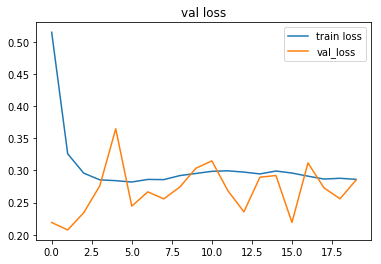

In [13]:
plt.plot(train_loss); plt.title('train loss')
plt.plot(val_loss); plt.title('val loss')
plt.legend(['train loss', 'val_loss'])

(0, 1)

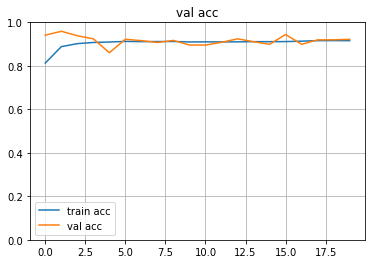

In [14]:
plt.plot(train_acc); plt.title('train acc')
plt.plot(val_acc); plt.title('val acc')
plt.legend(['train acc', 'val acc'])
plt.grid(True)
plt.ylim(0,1)

In [149]:
gestures = ['none', 'left', 'right', 'click', 'wrist']

In [15]:
np.save('X.npy', X)
np.save('y.npy', y)